In [1]:
import numpy as np
import pandas as pd
import os.path
from designstorm import StormDesignerCorrectedERA5, ERA5Downloader
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
# setting parameters
nc_fn = os.path.join('era', 'TJ_prec_1979-2018.nc')
shp_fn = os.path.join('shp', 'tj_catchments_wgs84.shp')
lat_lon_box = [42, 66, 36, 77]

In [3]:
# Download ERA5 data in nc_fn does not exist. Need cdsapi and credentials for ERA5 download installed.
# For this example you can download TJ data from https://www.dropbox.com/s/ql0wjkg0fobq0q5/TJ_prec_1979-2018.7z?dl=1
if not os.path.exists(nc_fn):
    d = ERA5Downloader(nc_fn)
    d.set_latlon_box(*lat_lon_box)
    d.set_years([2018, 2019])
    d.run()

In [8]:
%%time
# Download stations data from GHCN and prepare input for bias correction
from GHCNdaily import Inventory, Meta, read_dly
inv = Inventory('./ghcn_data/ghcn-inventory.txt')
inv_tbl = inv.filter(element='PRCP', lat_lon_box=lat_lon_box)
meta = Meta('./ghcn_data/ghcnd-stations.txt').get_meta(inv_tbl ['st_id'])
sts = [read_dly('./ghcn_data/%s.dly' % stid, 'PRCP')['PRCP'] for stid in meta['st_id']]
coors = list(zip(meta['lat'], meta['lon']))
stations_dat = pd.DataFrame(sts, index=np.arange(len(sts))).transpose()
stations_dat[stations_dat < 0] = np.nan
stations_dat = stations_dat / 10

D:\proj_local\TJ_for_AGU\env\lib\site-packages\pandas\core\computation\expressions.py:190: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  warnings.warn(


Wall time: 33.4 s


In [9]:
%%time
# High level class for bias corrected design storms
ds = StormDesignerCorrectedERA5(nc_fn, shp_fn, stations_dat, coors=coors, empty_shapes='nearest')


Wall time: 45.3 s


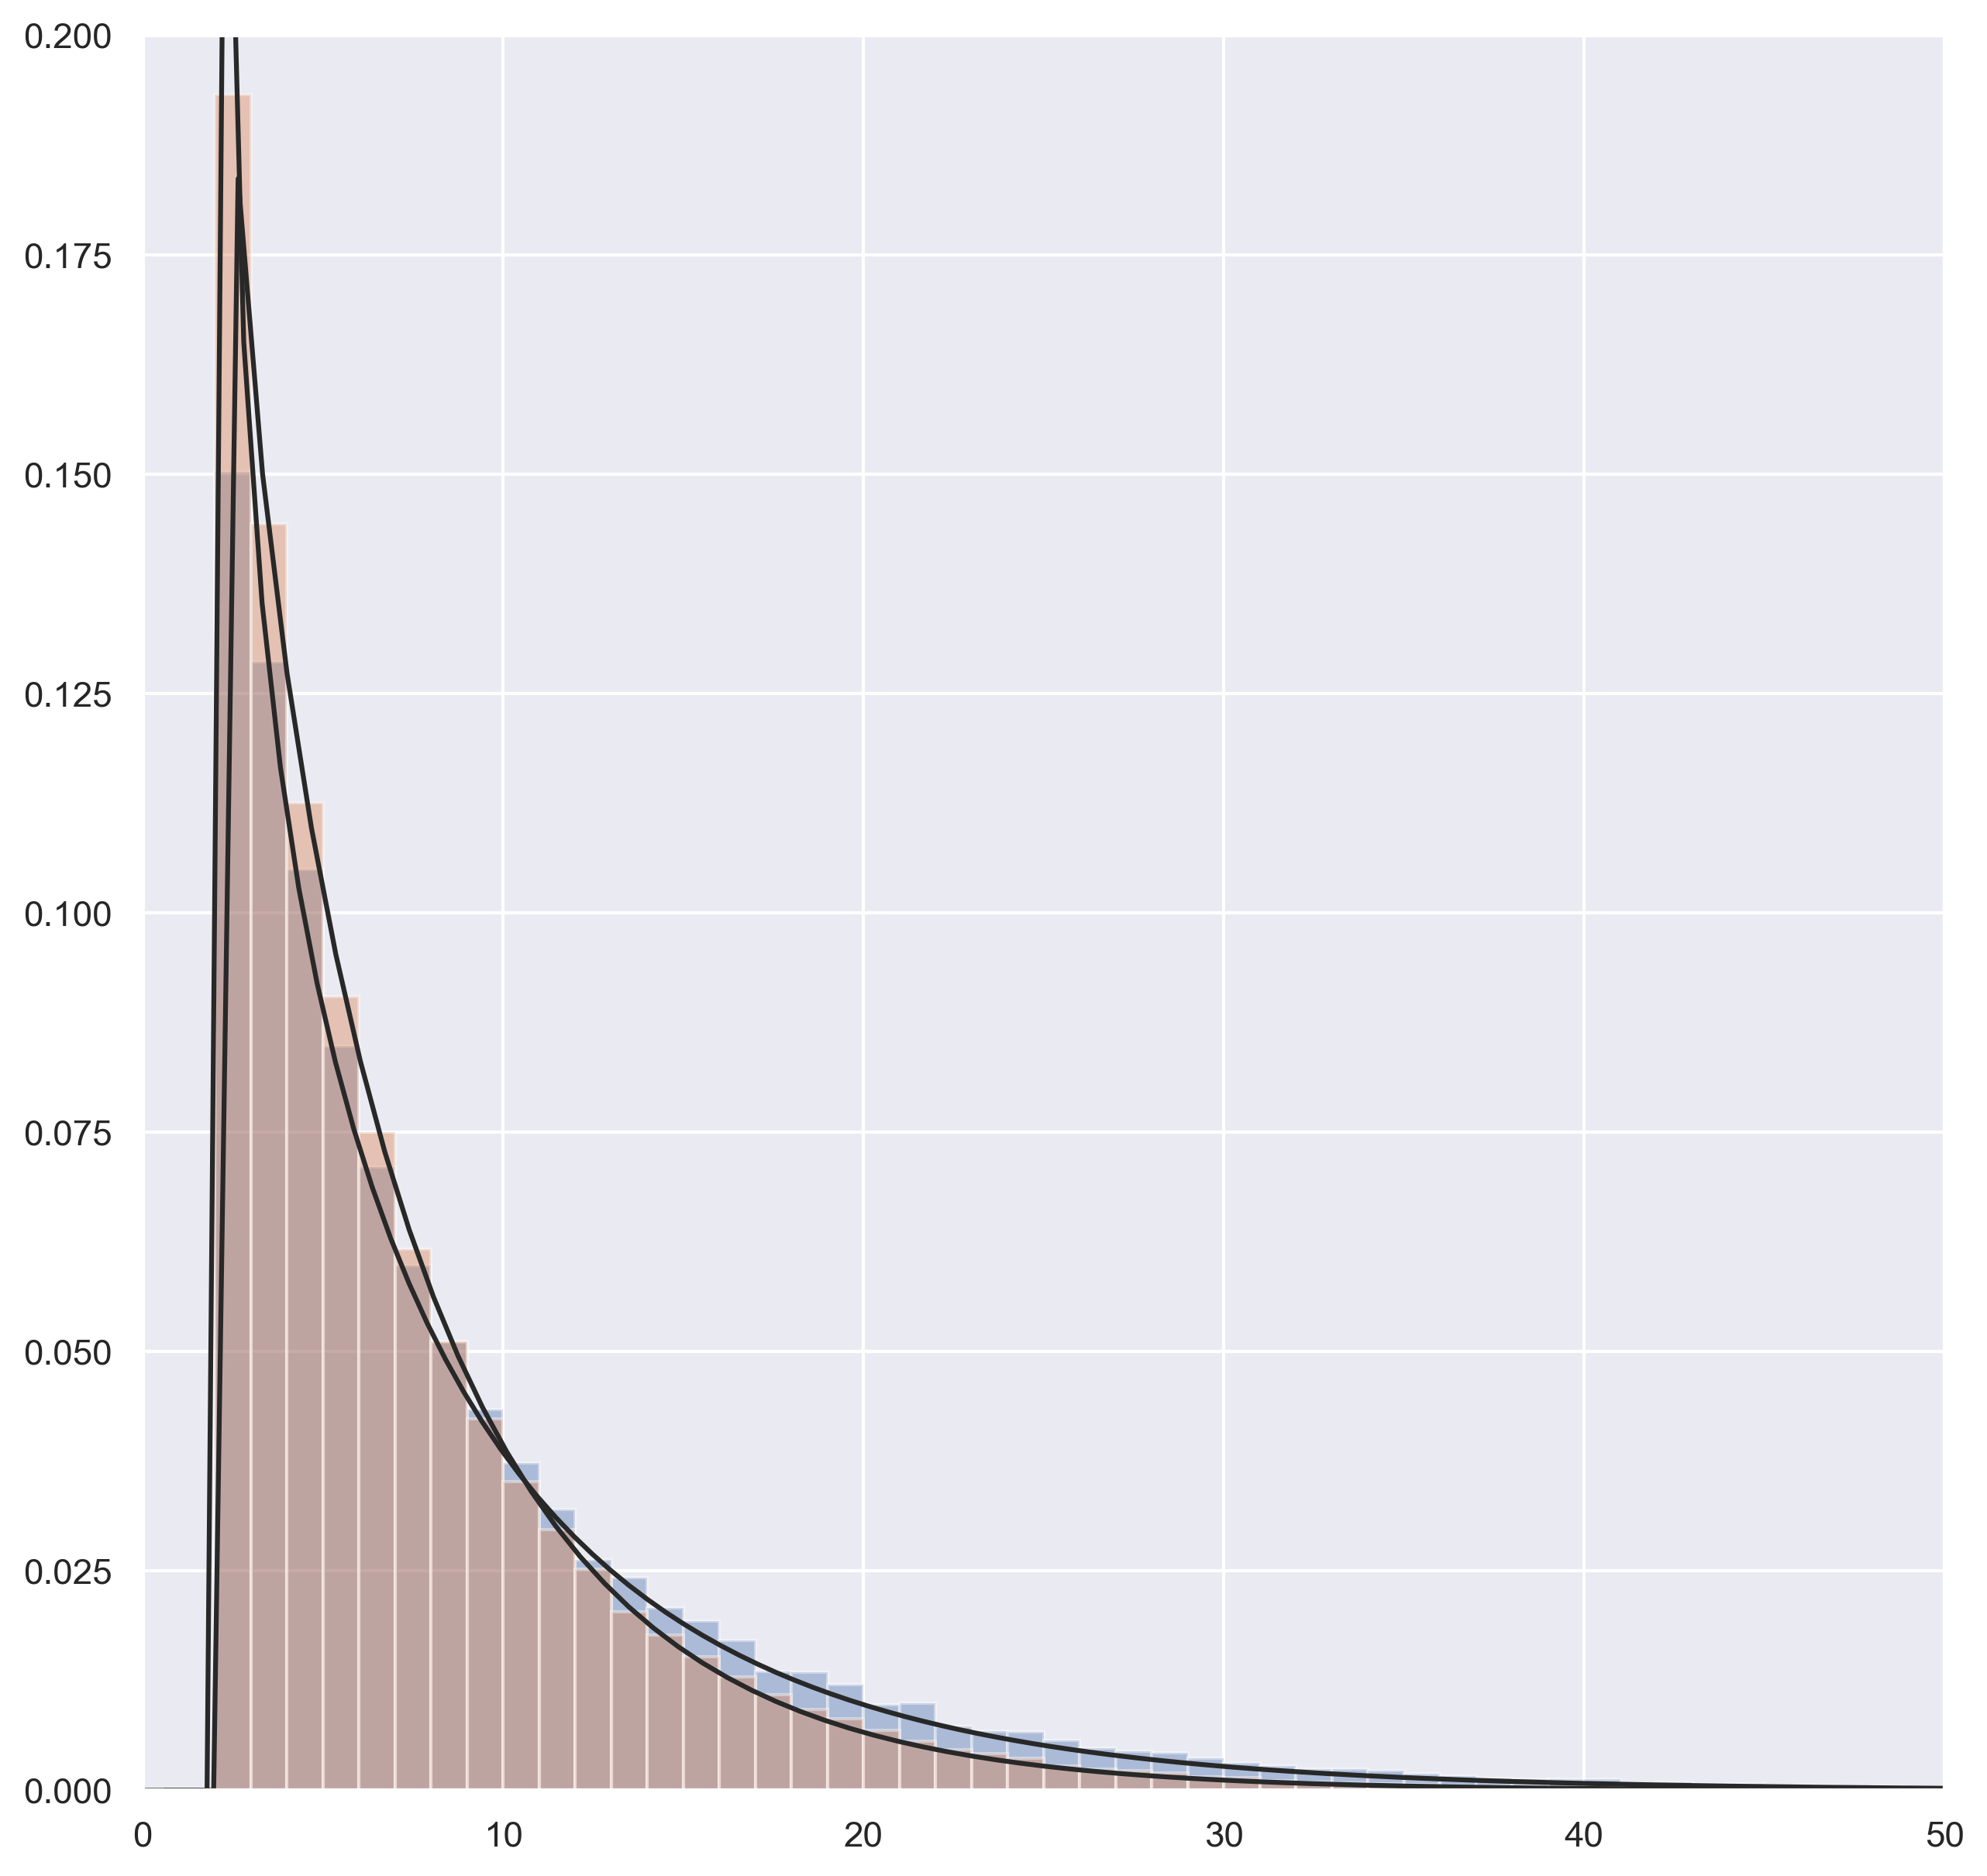

In [10]:
# plot histogram of bias corrected and original data
import seaborn
seaborn.set()
import scipy.stats
bc = ds.get_bc_obj(5)
# 
fig = plt.figure(figsize=(10, 10), dpi=300)
seaborn.distplot(bc.ta_flat[bc.ta_flat > bc.z_value], bins=np.arange(50), fit=scipy.stats.pearson3, kde=False)
seaborn.distplot(bc.ba_flat[bc.ba_flat > bc.z_value], bins=np.arange(50), fit=scipy.stats.pearson3, kde=False)
plt.xlim([0,50])
plt.ylim([0,0.2])
plt.savefig('hist.pdf')

0.7017258992465428 1.284857321177423 0.9998110172202088 3.0546405650007704e-171 0.0013713161322452623
[0.7017259  1.28485732]
Wall time: 780 ms


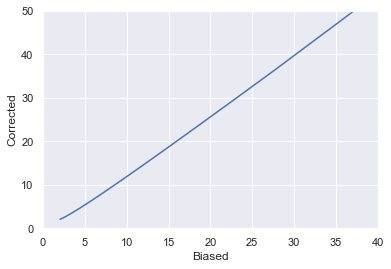

In [11]:
%%time
# Line plot of bias corrected vs original data
bc = ds.get_bc_obj(5)
quants = [1 * 10 ** -16] + [v/100 for v in range(1,100)] + [1 - (1 * 10 ** -16)]
true = [bc.true_distr.ppf(q) for q in quants]
biased = [bc.biased_distr.ppf(q) for q in quants]
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(true, biased)
print(slope, intercept, r_value, p_value, std_err)
c = np.polyfit(true, biased, deg=1)
print(c)
plt.plot(biased, true)
plt.grid()
# plt.plot(np.arange(300), np.arange(300))
plt.grid()
plt.xlim([0,40])
plt.ylim([0,50])
plt.xlabel('Biased')
plt.ylabel('Corrected')
plt.savefig('corrected.pdf')

In [ ]:
# os.environ["PROJ_LIB"] = r'D:\proj_local\TJ_for_AGU\env\Library\share'
import cmocean
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import ListedColormap

def plot_map(rp_map, fn =None, cmap='rain', pcolormesh_kws={}):
    if cmap == 'rain':
        cm = cmocean.cm.rain
        cmap = ListedColormap(cm(np.linspace(0, 1, 8)))
    fig = plt.figure(figsize=(10, 10), dpi=300)
    map = Basemap(projection='aeqd', 
              lat_0=ds.lats.mean(), lon_0=ds.lons.mean(),
              llcrnrlon=ds.lons[0]+1, 
              llcrnrlat=ds.lats[-1], 
              urcrnrlon=ds.lons[-1], 
              urcrnrlat=ds.lats[0], resolution='i')
    
    x, y = np.meshgrid(ds.lons, ds.lats)
    xx,yy = map(x,y)
    im = map.pcolormesh(xx, yy, rp_map, cmap=cmap, **pcolormesh_kws)
    map_coors = [map(stc[1], stc[0]) for stc in coors]
    map.plot([v[0] for v in map_coors], [v[1] for v in map_coors], marker='o', color='#631a35', linestyle='None')
    map.readshapefile('./shp/tj_catchments_wgs84', 'catchments_shape', linewidth=1)
    # map.drawrivers()
    map.drawcountries(linewidth=2)
    map.drawparallels(ds.lats)
    map.drawmeridians(ds.lons)
    fig.colorbar(im, orientation='horizontal', fraction=.1)
    plt.tight_layout()
    if fn is not None:
        plt.savefig(fn)
        plt.close()
    else:
        plt.show()

rp_map = ds.get_rp_map(50)
plot_map(rp_map)